## Creating Timelines to Visualize Time-to-Publication Across Each Experimental Hall

#### The code below uses an Excel document that contains the experiment numbers and start dates for each hall (one sheet for each hall), including only 12 GeV experiments (with the exception of Hall B's sheet, which contains other experiments as well)

In [8]:
# Create dictionary with experiment data from Excel document
import pandas as pd

# Load the Excel file 
df = pd.read_excel('HallExperiments.xlsx', sheet_name = 'Hall D') # Replace D with desired hall (A, B, C, or D)
df['Start Date'] = pd.to_datetime(df['Start Date']).dt.date
df['Start Date'] = df['Start Date'].astype(str)

# Convert the DataFrame to a list of dictionaries (one per row)
exp_data = df.to_dict(orient='records')
print(exp_data)

[{'Experiment': 'E12-06-102', 'Number': 1206102, 'Start Date': '2016-02-01', 'End Date': '2018-11'}, {'Experiment': 'E12-10-011', 'Number': 1210011, 'Start Date': '2018-11-01', 'End Date': '2022-12'}, {'Experiment': 'E12-12-002', 'Number': 1212002, 'Start Date': '2019-02-01', 'End Date': '2023-03'}, {'Experiment': 'E12-19-003', 'Number': 1219003, 'Start Date': '2021-11-01', 'End Date': '2021-12'}, {'Experiment': 'E12-13-008', 'Number': 1213008, 'Start Date': '2022-06-01', 'End Date': '2022-08'}]


#### The code below accesses the database and matches the publications to experiments in the Excel sheet

In [17]:
# Import "requests" to make HTTP requests
# Sort published papers based on hall, type, and publication date
import requests
jrdb_host = "https://jrdb.jlab.org"
url = f"{jrdb_host}/api/records"

headers = {
    'Authorization': 'Bearer API-TOKEN', # Enter API token
    'Accept': 'application/json'  # Optional: specify the desired content type
}

hall_articles = []
for x in exp_data:
    y = x['Number']
    params = {
        'q': f'custom_fields.rdm\:expID:{y}',  # Replace with your search query
        'sort': 'publication',  # Replace with your desired sorting option
        'size': 200,  # Replace with the number of items per page
        'page': 1,  # Replace with the page number
        'allversions': False  # Replace with True if you want all versions included
    }

    response = requests.get(url, headers=headers, params=params, verify=False)
    result = response.json()
    records = result['hits']['hits']

    articles = []
    thesis = []
    for key in records:
        # Filter by journal article
        if key["metadata"]["resource_type"]["id"] == 'publication-article':
            # Filter by communities
            if key["parent"]["communities"]["entries"][0]["slug"] == 'publicationdb':
                #Filter by hall 
                 if key ["custom_fields"]["rdm:full_division"] == 'Exp Nuclear Physics / Experimental Halls / Hall D':
                    # Filter by publication date
                    if key["metadata"]["publication_date"] > x['Start Date']:
                        # Filter by type of journal
                        if key ["custom_fields"]["journal:journal"]["title"] in ['Physical Review Letters', 'Physical Review C', 'Physical Review D', 'Physics Letters B', 'Nature', 'Science']:
                            hall_articles.append(key)
        # Filter by thesis
        elif key ["metadata"]["resource_type"]["id"] == 'publication-thesis':
            if key["metadata"]["publication_date"] > x['Start Date']:
                hall_articles.append(key)
    hall_articles.append(articles)
    hall_articles.append(thesis)

    #print(len(records))
    #print(len(articles))
    #print(len(thesis))
    #print(len(hall_articles))
    #print(hall_articles)

C:\Users\alexa\anaconda3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'jrdb.jlab.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
C:\Users\alexa\anaconda3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'jrdb.jlab.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
C:\Users\alexa\anaconda3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'jrdb.jlab.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
C:\Users\alexa\anaconda3\Lib\site-packages\urllib3\connectionpoo

#### This list of articles can be saved as a file and the remaining code below can be used

### The code below uses the zip files attached provided by Matthew Breton

In [9]:
# Open file containing all Hall X publications
import pickle
with open('Current\Current\HallD.pk1', 'rb') as file: # Replace D with desired hall
	pub_data = pickle.load(file)

#print(pub_data)

In [10]:
# Lists each publication with its publication date and type, along with the experiment(s) it is linked to 
pub_info_by_exp = {}
    
for i, key in enumerate(pub_data):
    pub_info_by_exp[i] = []
    for x in pub_data[key]:
        if x["metadata"]["resource_type"]["id"] == 'publication-thesis':
            pub_type = 'Thesis'
        else:
            pub_type = x["custom_fields"]["journal:journal"]["title"]
        pub_date = x["metadata"]["publication_date"]
        pub_exp = x["custom_fields"]["rdm:experiment_number"]

        pub_info_by_exp[i].append({"exp": pub_exp, "date": pub_date, "type": pub_type})

from datetime import datetime

def parse_date_with_defaults(date_str):
    # Parses dates (YYYY or YYYY-MM), filling missing parts with defaults
    parts = date_str.split("-")
    year = int(parts[0])
    month = int(parts[1]) if len(parts) > 1 else 1  # Default to January
    return datetime(year, month, 1)  # Default day to 1

# Apply the parser to the dictionary
for exp_list in pub_info_by_exp.values():
    for pub in exp_list:
        pub["date"] = parse_date_with_defaults(pub["date"])

# Lists each publication on a new line to make it easier to read
for key, pubs in pub_info_by_exp.items():
    print(f"{key}:")
    for pub in pubs:
        print(f"  {pub}")

0:
  {'exp': ['E12-06-102'], 'date': datetime.datetime(2025, 7, 1, 0, 0), 'type': 'Physical Review Letters'}
  {'exp': ['E12-06-102'], 'date': datetime.datetime(2025, 2, 1, 0, 0), 'type': 'Physics Letters B'}
  {'exp': ['E12-06-102'], 'date': datetime.datetime(2025, 1, 1, 0, 0), 'type': 'Physical Review C'}
  {'exp': ['E12-06-102'], 'date': datetime.datetime(2024, 12, 1, 0, 0), 'type': 'Physical Review Letters'}
  {'exp': ['E12-06-102', 'E12-12-002'], 'date': datetime.datetime(2024, 12, 1, 0, 0), 'type': 'Thesis'}
  {'exp': ['E12-06-102'], 'date': datetime.datetime(2024, 8, 1, 0, 0), 'type': 'Thesis'}
  {'exp': ['E12-06-102'], 'date': datetime.datetime(2024, 8, 1, 0, 0), 'type': 'Thesis'}
  {'exp': ['E12-06-102', 'E12-13-008'], 'date': datetime.datetime(2024, 5, 1, 0, 0), 'type': 'Thesis'}
  {'exp': ['E12-06-102'], 'date': datetime.datetime(2024, 3, 1, 0, 0), 'type': 'Thesis'}
  {'exp': ['E12-06-102'], 'date': datetime.datetime(2023, 12, 1, 0, 0), 'type': 'Thesis'}
  {'exp': ['E12-06-1

In [14]:
# Create two dictionaries for use in making the plots
data = {}
for row in exp_data:
    exp_id = row['Experiment']
    start_date = parse_date_with_defaults(row['Start Date'])
    data[exp_id] = {
        'exp_start': start_date,
        'publication_dates': []
    }

# Process publication information 
pub_types = {exp_id: [] for exp_id in data}  # Initialize all with empty lists

for exp_list in pub_data:
    for art in pub_data[exp_list]:
        if art["metadata"]["resource_type"]["id"] == 'publication-thesis':
            pub_type_full = 'Thesis'
        else:
            pub_type_full = art["custom_fields"]["journal:journal"]["title"]
        pub_exp_list = art["custom_fields"]["rdm:experiment_number"]
        pub_date_str = art["metadata"]["publication_date"]
        pub_date = parse_date_with_defaults(pub_date_str)

        # Convert full journal name to acronym
        if "Physics Letters B" in pub_type_full:
            short_type = "PLB"
        elif "Physical Review C" in pub_type_full:
            short_type = "PRC"
        elif "Physical Review Letters" in pub_type_full:
            short_type = "PRL"
        elif "Physical Review D" in pub_type_full:
            short_type = "PRD"
        elif "Nature" in pub_type_full:
            short_type = "Nature" 
        elif "Science" in pub_type_full:
            short_type = "Science" 
        elif "Thesis" in pub_type_full:
            short_type = "Thesis"
        else:
            short_type = "OTHER"

        # Assign to all matching experiments
        for exp_id in pub_exp_list:
            if exp_id in data:
                data[exp_id]['publication_dates'].append(pub_date)
                pub_types[exp_id].append(short_type)

# Final output
print("data = {")
for k, v in data.items():
    print(f"    '{k}': {{")
    print(f"        'exp_start': datetime({v['exp_start'].year}, {v['exp_start'].month}, {v['exp_start'].day}),")
    pubs = ', '.join([f"datetime({d.year}, {d.month}, {d.day})" for d in v['publication_dates']])
    print(f"        'publication_dates': [{pubs}]")
    print(f"    }},")
print("}")

print("\npub_types = {")
for k, v in pub_types.items():
    types_str = ', '.join([f'"{t}"' for t in v])
    print(f"    '{k}': [{types_str}],")
print("}")

data = {
    'E12-06-102': {
        'exp_start': datetime(2016, 2, 1),
        'publication_dates': [datetime(2025, 7, 1), datetime(2025, 2, 1), datetime(2025, 1, 1), datetime(2024, 12, 1), datetime(2024, 12, 1), datetime(2024, 8, 1), datetime(2024, 8, 1), datetime(2024, 5, 1), datetime(2024, 3, 1), datetime(2023, 12, 1), datetime(2023, 11, 1), datetime(2023, 8, 1), datetime(2023, 8, 1), datetime(2023, 4, 1), datetime(2022, 6, 1), datetime(2022, 5, 1), datetime(2022, 5, 1), datetime(2022, 4, 1), datetime(2022, 3, 1), datetime(2021, 2, 1), datetime(2019, 11, 1), datetime(2019, 8, 1), datetime(2017, 9, 1), datetime(2017, 4, 1), datetime(2012, 9, 1), datetime(2023, 1, 1), datetime(2024, 4, 1), datetime(2024, 5, 1), datetime(2024, 12, 1)]
    },
    'E12-10-011': {
        'exp_start': datetime(2018, 11, 1),
        'publication_dates': [datetime(2025, 1, 1), datetime(2024, 5, 1), datetime(2016, 1, 1)]
    },
    'E12-12-002': {
        'exp_start': datetime(2019, 2, 1),
        'publicat

C:\Users\alexa\AppData\Local\Temp\ipykernel_15564\1876617337.py:100: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("RdYlGn_r")
C:\Users\alexa\AppData\Local\Temp\ipykernel_15564\1876617337.py:120: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("RdYlGn_r")


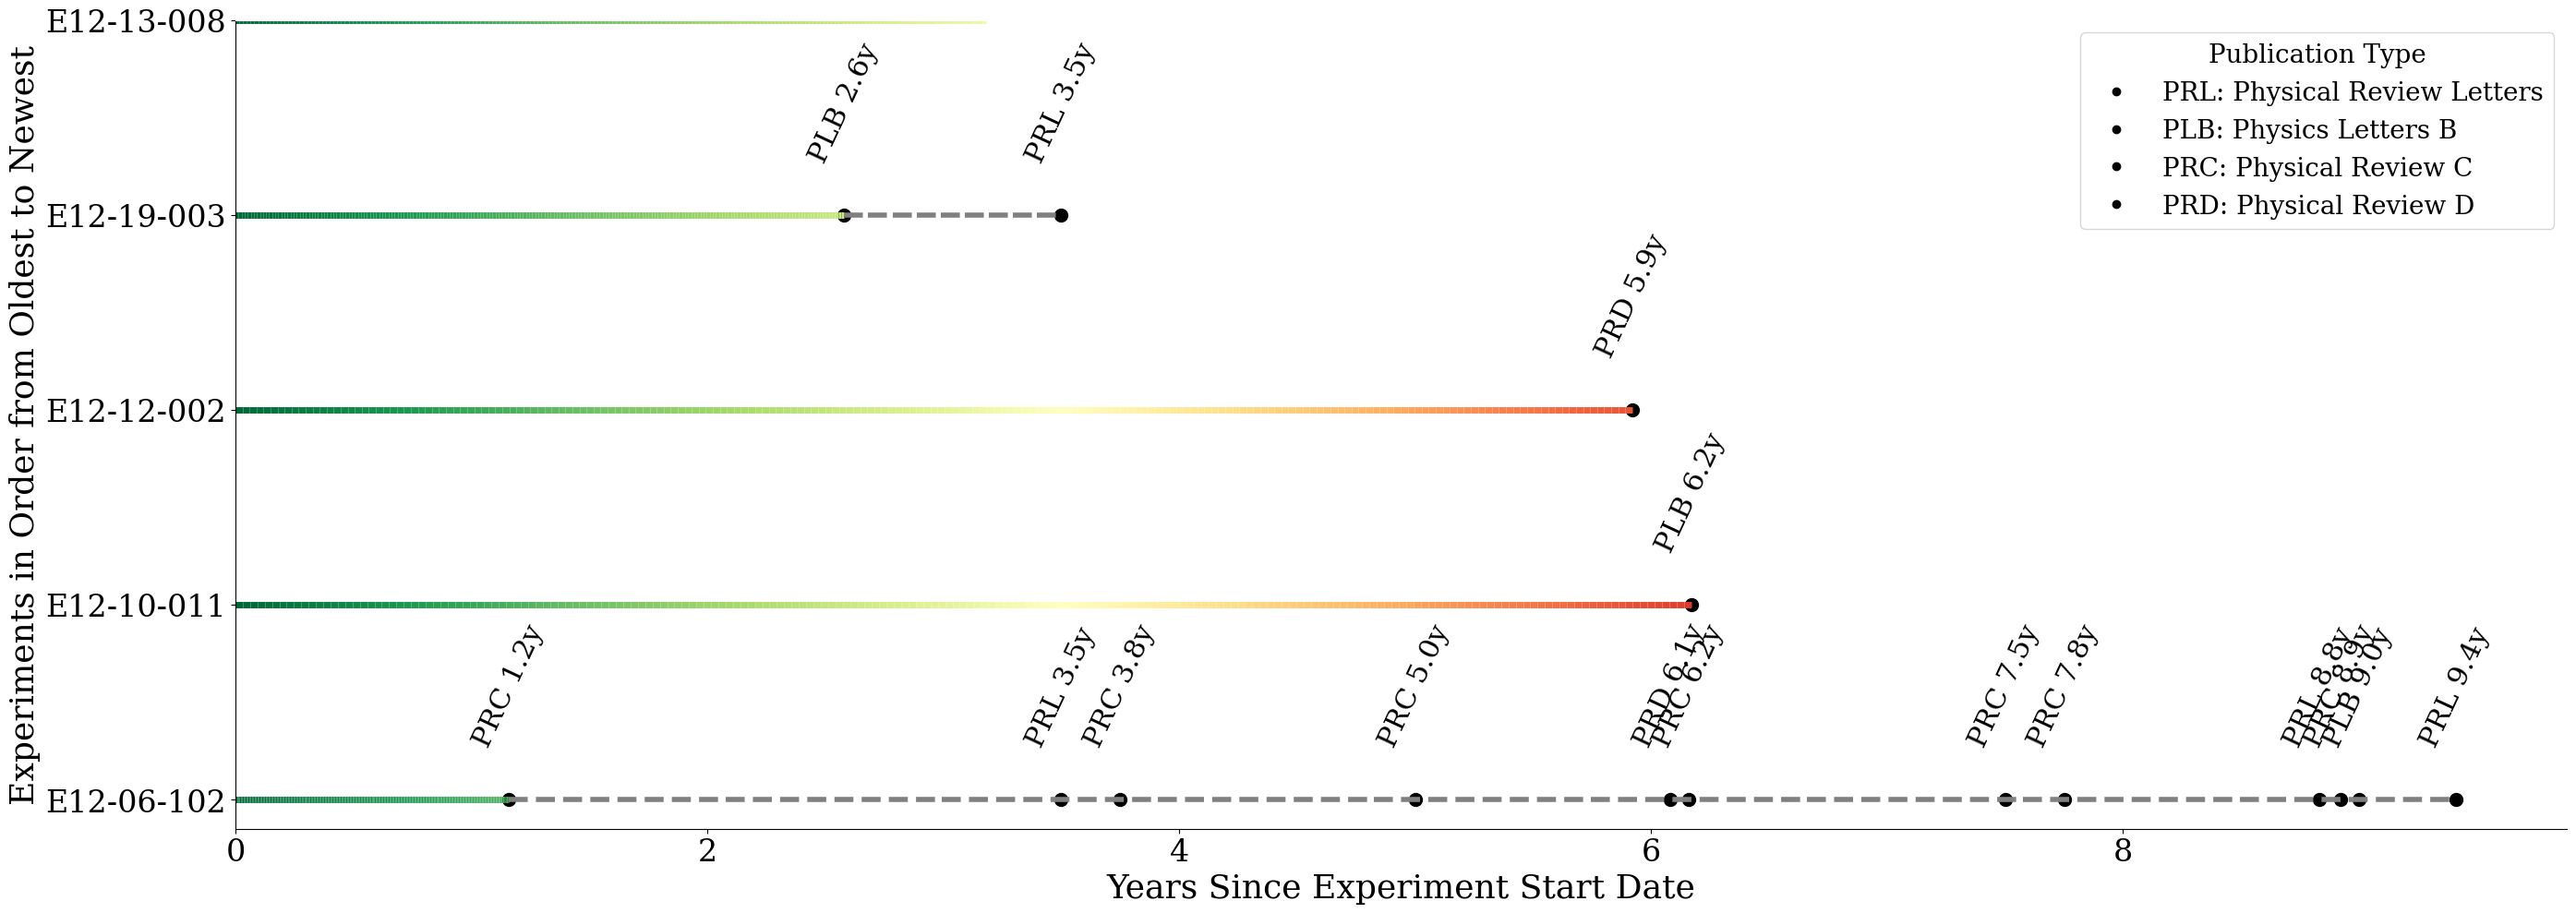

In [15]:
# Creates plot for journal articles only 
import matplotlib.pyplot as plt
from matplotlib import rcParams
from datetime import datetime
from adjustText import adjust_text
from matplotlib.collections import LineCollection
import matplotlib.colors as mcolors
import numpy as np

# Change font
rcParams['font.family'] = 'Serif'

# Adjust font sizes
plt.rcParams.update({
    'axes.titlesize': 24,       # Title font size
    'axes.labelsize': 26,       # X and Y label size
    'xtick.labelsize': 24,      # X tick size
    'ytick.labelsize': 24,      # Y tick size
    'legend.fontsize': 20,      # Legend text size
    'legend.title_fontsize': 20 # Legend title size
})

# Plot setup
fig, ax = plt.subplots(figsize=(28, 10))

group_spacing = 1.0
marker_height = 0.25

y_ticks = []
y_tick_labels = []
current_y = 0

for exp in data.keys():
    pubs = data[exp]['publication_dates']
    start = data[exp]['exp_start']
    types = pub_types[exp]

    pub_years = []

    for j, pub in enumerate(pubs):
        pub_type = types[j]
        if pub_type == "Thesis": 
            continue
        diff_years = round((pub - start).days / 365.25, 2)
        if diff_years <= 0: 
            continue
        pub_years.append(diff_years)

        label = f"{types[j]} {diff_years:.1f}y"

        # Customize style for Nature and Science
        if types[j] == "Nature":
            ax.text(
                diff_years,
                current_y + marker_height,
                label,
                ha='center',
                va='bottom',
                fontsize=26,         # Larger font size
                fontweight='bold',   # Bold font
                color='green',       # Custom color
                family='serif',      # Font style
                rotation=65
            )
            ax.plot(diff_years, current_y, marker='*', color='k', markersize=20)

        elif types[j] == "Science":
            ax.text(
                diff_years,
                current_y + marker_height,
                label,
                ha='center',
                va='bottom',
                fontsize=26,
                fontweight='bold',
                color='blue',
                family='serif',
                rotation=65
            )
            ax.plot(diff_years, current_y, marker='D', color='blue', markersize=20)
            
        else:
            ax.text(
                diff_years,
                current_y + marker_height,
                label,
                ha='center',
                va='bottom',
                fontsize=22,
                rotation=65
            )
            ax.plot(diff_years, current_y, marker='o', color='k', markersize=10)

    if pub_years:
        # Gradient line up to first publication
        x_first = min(pub_years)
        x_grad = np.linspace(0, x_first, 200)
        segments_grad = [[[x_grad[i], current_y], [x_grad[i+1], current_y]] for i in range(len(x_grad)-1)]

        cmap = plt.cm.get_cmap("RdYlGn_r")
        norm = plt.Normalize(vmin=0, vmax=7)
        colors_grad = [cmap(norm((x_grad[i] + x_grad[i+1]) / 2)) for i in range(len(x_grad)-1)]

        lc_grad = LineCollection(segments_grad, colors=colors_grad, linewidths=5, linestyles='dashed')
        ax.add_collection(lc_grad)

        # Dashed gray line from first to latest publication
        if len(pub_years) > 1:
            x_dash = np.linspace(x_first, max(pub_years), 10)
            segments_dash = [[[x_dash[i], current_y], [x_dash[i+1], current_y]] for i in range(len(x_dash)-1)]
            lc_dash = LineCollection(segments_dash, colors='gray', linewidths=4, linestyles='dashed')
            ax.add_collection(lc_dash)

    else:
        # No publications: gradient up to today's date
        x_end = round((datetime.today() - start).days / 365.25, 2)
        x_grad = np.linspace(0, x_end, 200)
        segments_grad = [[[x_grad[i], current_y], [x_grad[i+1], current_y]] for i in range(len(x_grad)-1)]

        cmap = plt.cm.get_cmap("RdYlGn_r")
        norm = plt.Normalize(vmin=0, vmax=7)
        colors_grad = [cmap(norm((x_grad[i] + x_grad[i+1]) / 2)) for i in range(len(x_grad)-1)]

        lc_grad = LineCollection(segments_grad, colors=colors_grad, linewidths=5, linestyles='dashed')
        ax.add_collection(lc_grad)

    y_ticks.append(current_y)

    y_tick_labels.append(exp)
    current_y += group_spacing

# Format y-axis
ax.set_yticks(y_ticks)
ax.set_yticklabels(y_tick_labels)
ax.set_xlim(left=0)

# Legend labels
type_labels = {
    "PRL": "PRL: Physical Review Letters",
    "PLB": "PLB: Physics Letters B",
    "PRC": "PRC: Physical Review C",
    "PRD": "PRD: Physical Review D"
}

# Add legends
handles = [plt.Line2D([0], [0], marker='o', color='k', linestyle='None') for k in type_labels]
labels = [type_labels[k] for k in type_labels]
ax.legend(handles, labels, title="Publication Type")

# Axis labels and title
ax.set_xlabel("Years Since Experiment Start Date")
ax.set_ylabel("Experiments in Order from Oldest to Newest")
#ax.set_title("Hall X Experiments and Corresponding Publications")

# Aesthetic tweaks
ax.spines['top'].set_color('white')
ax.spines['right'].set_color('white')
plt.tight_layout()
plt.show()

C:\Users\alexa\AppData\Local\Temp\ipykernel_15564\2757533507.py:81: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("RdYlGn_r")
C:\Users\alexa\AppData\Local\Temp\ipykernel_15564\2757533507.py:101: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("RdYlGn_r")


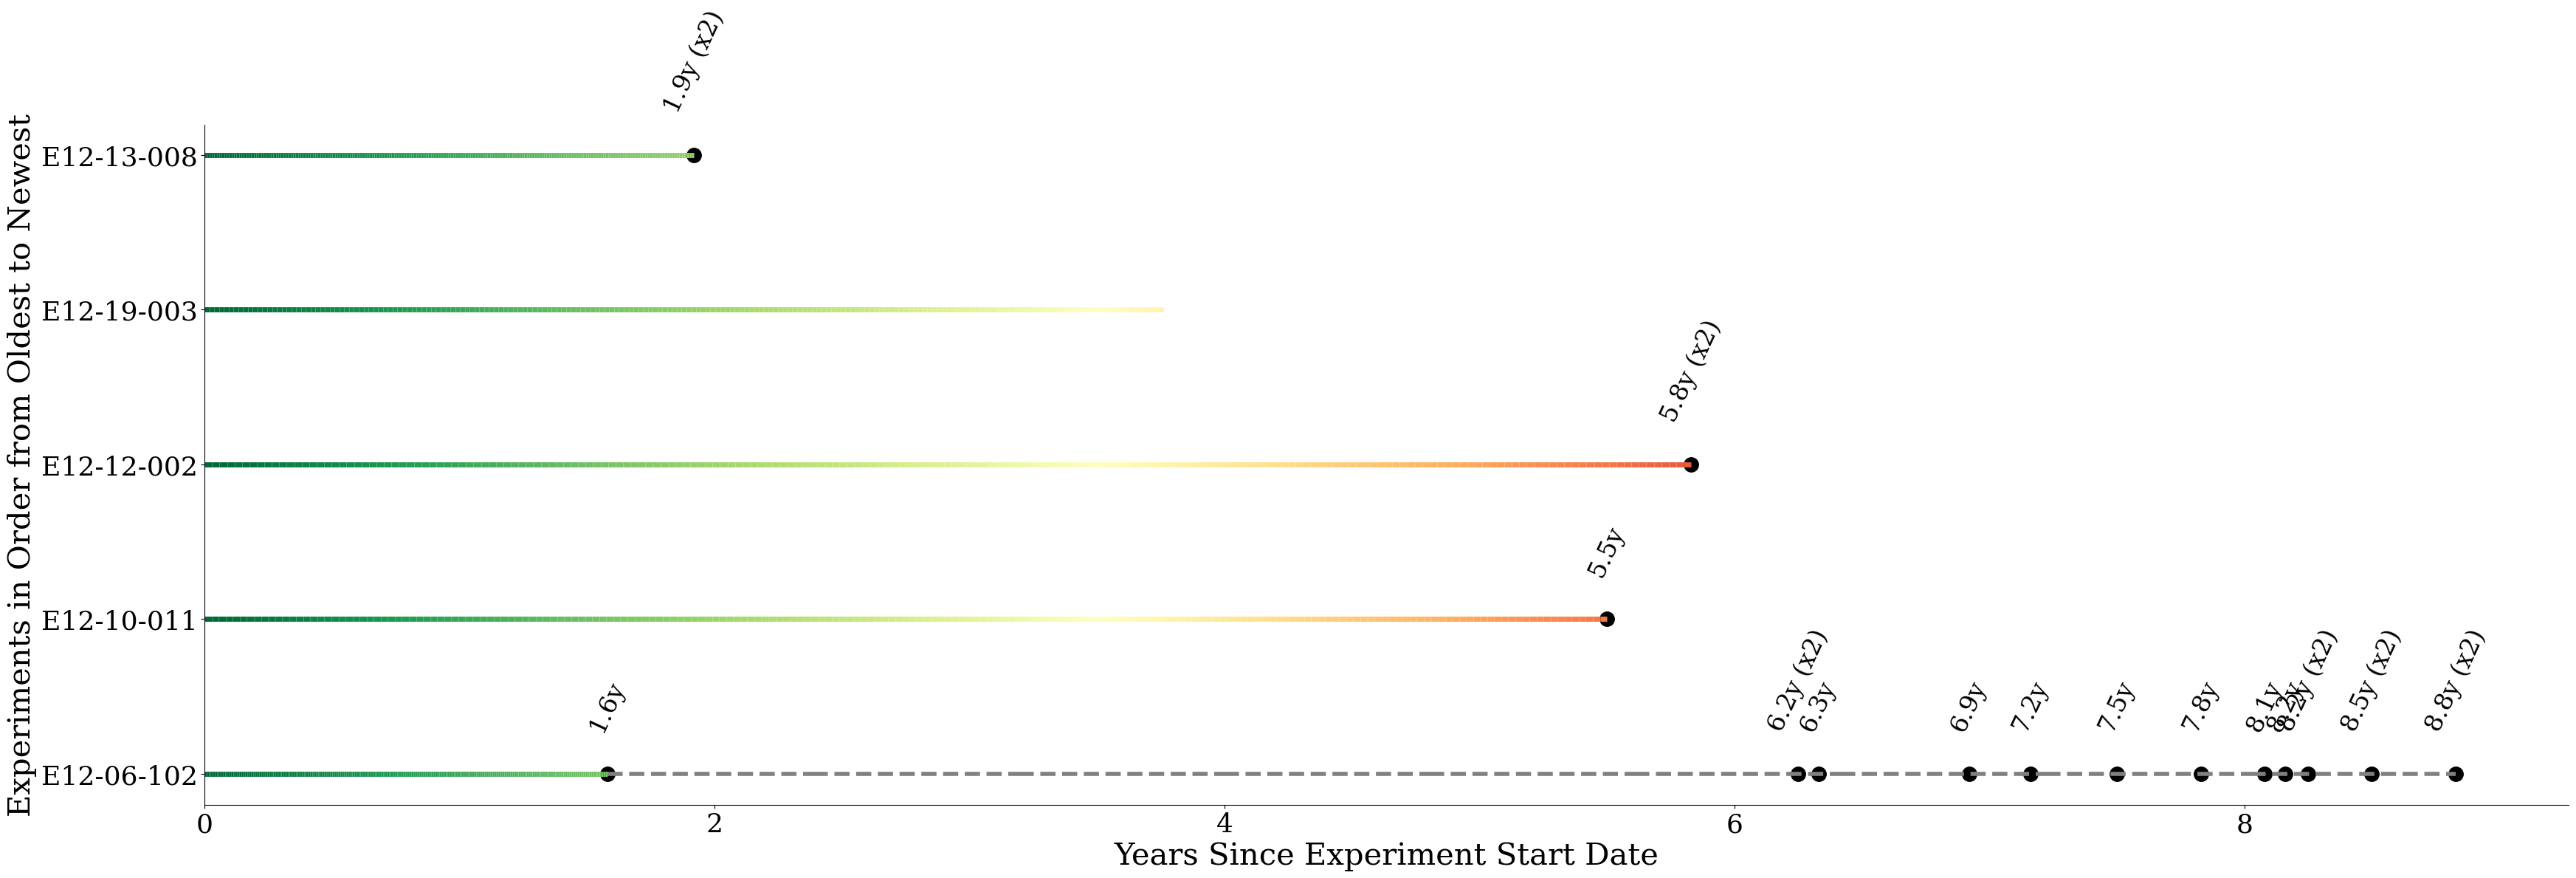

In [16]:
# Creates plot for theses only 
import matplotlib.pyplot as plt
from matplotlib import rcParams
from datetime import datetime
from adjustText import adjust_text
from matplotlib.collections import LineCollection
import matplotlib.colors as mcolors
import numpy as np

# Change font
rcParams['font.family'] = 'Serif'

# Adjust font sizes
plt.rcParams.update({
    'axes.titlesize': 24,       # Title font size
    'axes.labelsize': 30,       # X and Y label size
    'xtick.labelsize': 26,      # X tick size
    'ytick.labelsize': 26,      # Y tick size
    'legend.fontsize': 26,      # Legend text size
    'legend.title_fontsize': 26 # Legend title size
})

# Plot setup
fig, ax = plt.subplots(figsize=(35, 12))

group_spacing = 1.0
marker_height = 0.25

y_ticks = []
y_tick_labels = []
current_y = 0

for exp in data.keys():
    pubs = data[exp]['publication_dates']
    start = data[exp]['exp_start']
    types = pub_types[exp]

    pub_years = []

    from collections import defaultdict

    # Count how many publications have the same number of years to publication
    pub_count = defaultdict(int)
    pub_entries = []

    for j, pub in enumerate(pubs):
        pub_type = types[j]
        if pub_type != "Thesis":
            continue
        diff_years = round((pub - start).days / 365.25, 2)
        if diff_years <= 0:
            continue
        pub_years.append(diff_years)
        pub_count[(pub_type, diff_years)] += 1
        pub_entries.append((pub_type, diff_years))

    plotted = set()
    for pub_type, diff_years in pub_entries:
        if (pub_type, diff_years) in plotted:
            continue
        plotted.add((pub_type, diff_years))
        count = pub_count[(pub_type, diff_years)]

        # Draw marker
        ax.plot(diff_years, current_y, marker='o', color='k', markersize=14)

        # Label with count if more than one
        label = f"{diff_years:.1f}y"
        if count > 1:
            label += f" (x{count})"
    
        ax.text(diff_years, current_y + marker_height, label,
                ha='center', va='bottom', fontsize=24, rotation=65)

    if pub_years:
        # Gradient up to first publication
        x_first = min(pub_years)
        x_grad = np.linspace(0, x_first, 200)
        segments_grad = [[[x_grad[i], current_y], [x_grad[i+1], current_y]] for i in range(len(x_grad)-1)]

        cmap = plt.cm.get_cmap("RdYlGn_r")
        norm = plt.Normalize(vmin=0, vmax=7)
        colors_grad = [cmap(norm((x_grad[i] + x_grad[i+1]) / 2)) for i in range(len(x_grad)-1)]

        lc_grad = LineCollection(segments_grad, colors=colors_grad, linewidths=5, linestyles='dashed')
        ax.add_collection(lc_grad)

        # Dashed gray line from first to latest publication
        if len(pub_years) > 1:
            x_dash = np.linspace(x_first, max(pub_years), 10)
            segments_dash = [[[x_dash[i], current_y], [x_dash[i+1], current_y]] for i in range(len(x_dash)-1)]
            lc_dash = LineCollection(segments_dash, colors='gray', linewidths=4, linestyles='dashed')
            ax.add_collection(lc_dash)

    else:
        # No publications: gradient up to today's date
        x_end = round((datetime.today() - start).days / 365.25, 2)
        x_grad = np.linspace(0, x_end, 200)
        segments_grad = [[[x_grad[i], current_y], [x_grad[i+1], current_y]] for i in range(len(x_grad)-1)]

        cmap = plt.cm.get_cmap("RdYlGn_r")
        norm = plt.Normalize(vmin=0, vmax=7)
        colors_grad = [cmap(norm((x_grad[i] + x_grad[i+1]) / 2)) for i in range(len(x_grad)-1)]

        lc_grad = LineCollection(segments_grad, colors=colors_grad, linewidths=5, linestyles='dashed')
        ax.add_collection(lc_grad)

    y_ticks.append(current_y)

    y_tick_labels.append(exp)
    current_y += group_spacing

# Format y-axis
ax.set_yticks(y_ticks)
ax.set_yticklabels(y_tick_labels)
ax.set_xlim(left=0)

# Axis labels and title
ax.set_xlabel("Years Since Experiment Start Date")
ax.set_ylabel("Experiments in Order from Oldest to Newest")
#ax.set_title("Hall X Experiments' Theses")

# Aesthetic tweaks
ax.spines['top'].set_color('white')
ax.spines['right'].set_color('white')
plt.tight_layout()
plt.show()